In [1]:
from pathlib import Path
import numpy as np
import scipy as sp
import pandas as pd
from PIL import Image

In [2]:
HERE = Path().resolve()
# EXAMPLE_DIR = HERE / "hot-air-balloons"
# EXAMPLE_DIR = HERE / "hot-air-balloons-2"
EXAMPLE_DIR = HERE / "superheroes-1"
DEPTH_PATH = EXAMPLE_DIR / "depth.png"
IMG_PATH = EXAMPLE_DIR / "img.png"
OUT_PATH = EXAMPLE_DIR / "shifted.png"

def example(ex_dir):
    return {
        "img": HERE / ex_dir / "img.png",
        "depth": HERE / ex_dir / "depth.png",
    }

EXAMPLES = {
    "simple": example("simple"),
    "superheroes-1": example("superheroes-1"),
}

NIL = [0, 0, 0, 0]
WHITEA = [255, 255, 255, 255]
BLACKA = [0, 0, 0, 255]
WHITE = [255, 255, 255]
BLACK = [0, 0, 0]


In [3]:

def get_image_data(example):
    img = Image.open(EXAMPLES[example]["img"].open("rb"))
    img = img.convert("RGBA")
    data = np.array(img)
    return data

def get_depth_data(example, shift_amount : int):
    depth_img = Image.open(EXAMPLES[example]["depth"].open("rb"))
    depth_img = depth_img.convert("L")
    depth_data = np.array(depth_img)
    deltas = np.array((depth_data / 255.0) * float(shift_amount), dtype=int)
    return deltas

In [4]:
def get_shifted_data_1(data, deltas):
    shifted_data = np.zeros_like(data)
    for y, row in enumerate(deltas):
        width = len(row)
        x = 0
        while x < width:
            dx = row[x]
            if x+dx >= width:
                break
            shifted_data[y][x+dx] = data[y][x]
            x += dx or 1
    return shifted_data

In [7]:
def stereo_size(left : Image, right : Image):
    return (left.width + right.width, max(left.height, right.height))

In [8]:
def perform(example_name, shift_amount, shift_f):
    img_data = get_image_data(example_name)
    deltas = get_depth_data(example_name, shift_amount)
    shifted_data = shift_f(img_data, deltas)

    return (img_data, deltas, shifted_data)

def perform2img(example_name, shift_amount, shift_f, deltas_mode="L", img_mode="RGBA"):
    (img_data, deltas, shifted_data) = perform(example_name, shift_amount, shift_f)
    return (
        Image.fromarray(img_data, img_mode),
        Image.fromarray(deltas, "L"),
        Image.fromarray(shifted_data, img_mode)
    )

def create_stereo_pair(left : Image, right : Image, mode="RGB"):
    pair = Image.new(mode, stereo_size(left, right))
    pair.paste(left)
    pair.paste(right, (left.width, 0))
    return pair

In [12]:
(left, _, right) = perform2img("superheroes-1", 3, get_shifted_data_1)
stereo = create_stereo_pair(left, right)
stereo
# stereo.resize((250, 125), Image.Resampling.NEAREST)

In [9]:
# Let's see if reversing does the trick
def get_shifted_data_reverse(data, deltas):
    shifted_data = np.zeros_like(data)
    for y, row in enumerate(deltas):
        width = len(row)
        x = 0
        while x < width:
            dx = row[x]
            if x+dx >= width:
                break
            shifted_data[y][x-dx] = data[y][x]
            # shifted_data[y][x-dx] = data[y][x]
            x += 1
    return shifted_data

(left, depth_image, right) = perform2img("superheroes-1", 20, get_shifted_data_reverse)
right.save("./bad-shifted-1.png")

ValueError: Could not save to JPEG for display

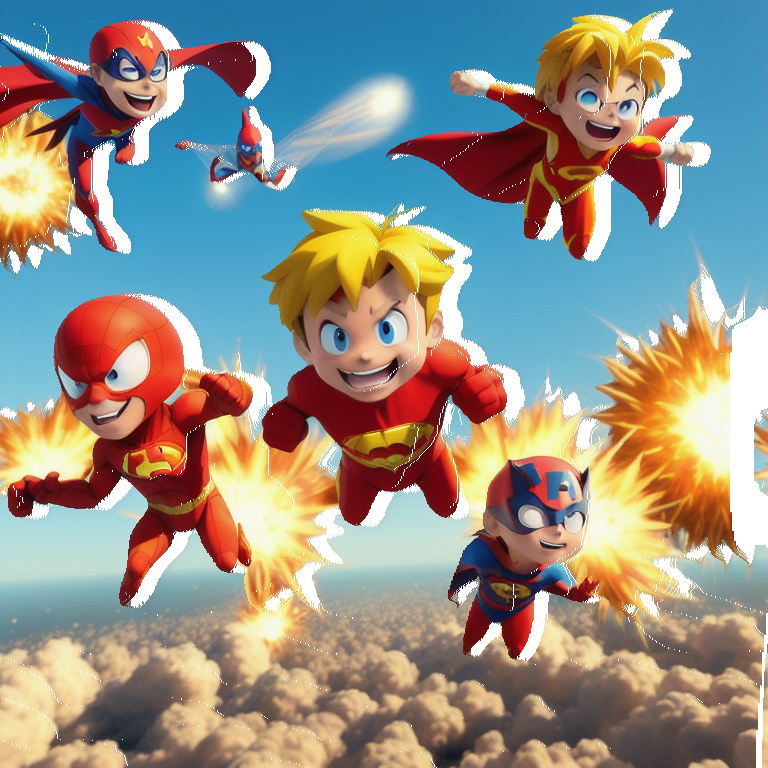

In [85]:
from scipy import ndimage
from PIL import ImageChops
def trans_to_bw(img : Image):
    return ImageChops.invert(img.getchannel("A"))

new_alpha = Image.fromarray(ndimage.binary_fill_holes(ImageChops.invert(right.getchannel("A")))).convert("1")
right.putalpha(ImageChops.invert(new_alpha))
right

In [ ]:
from scipy import ndimage
from PIL import ImageChops
depth_data = get_depth_data("superheroes-1", 10)
ndimage.shift(left, depth_data, )